In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC as SVM
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV

[1] Используя make_blobs с любым random_state, сгенерировать датасет df1, в котором есть три класса с размером каждого класса 1000 и четыре количественных (недискретных) признака.

In [3]:
x, y = make_blobs(n_samples=3*1000, n_features=4, random_state=13)

df1 = pd.DataFrame(x)
df1['target'] = y
df1 = df1.sort_values(by='target').reset_index(drop=True)

display(df1)

,0,1,2,3,target
0,4.342477,-6.680644,5.825188,9.759512,0
1,6.684134,-4.991616,7.089087,7.306308,0
2,4.827130,-5.436103,7.374937,8.455655,0
3,4.563817,-5.676905,8.273967,8.604181,0
4,5.429488,-6.266944,7.305702,11.267995,0
...,...,...,...,...,...
2995,3.268372,4.027791,-9.480631,-5.448016,2
2996,1.776783,4.517453,-9.325650,-4.292892,2
2997,2.032948,6.363195,-9.183246,-5.406391,2
2998,3.162120,4.860334,-8.981218,-5.817301,2


[2] Не забываем повторять шаги с задания 1
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

In [4]:
feature_columns = [col for col in df1.columns if col not in ['target', 'id']]
display(df1.describe())

statistics = {"Shape": f"({df1.shape[0]}, {df1.shape[1]})",
              "Features": len(feature_columns),
              "Classes": df1['target'].nunique(),
              "Entries": f"{df1['target'].value_counts().reset_index()['count'].tolist()}",
              # "Missing": f"{[str((df1[i].isnull().sum() / len(df1[i])) * 100) for i in feature_columns]}",
              "Missing": f'{df1.isnull().mean().sum() * 100} %'}

df1_statistics = pd.DataFrame(statistics, index=[0])
display(df1_statistics)

,0,1,2,3,target
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,5.936082,-0.569438,-0.185438,3.631724,1.000000
std,2.897177,4.078057,6.770528,5.702396,0.816633
min,-0.265214,-8.674837,-13.100734,-6.887861,0.000000
25%,3.443756,-4.593990,-8.661796,-3.320119,0.000000
50%,5.454844,-0.889803,2.246013,5.543222,1.000000
75%,8.819810,3.780867,5.886136,8.638008,2.000000
max,13.092824,7.210855,10.023993,12.416847,2.000000


,Shape,Features,Classes,Entries,Missing
0,"(3000, 5)",4,3,"[1000, 1000, 1000]",0.0 %


In [5]:
correlation_matrix = df1.corr()

print("Dataset correlation matrix:")
display(correlation_matrix)

for class_value in df1['target'].unique():
    class_df = df1[df1['target'] == class_value].drop(columns=['target'])
    corr_matrix_class = class_df.corr()
    
    print(f'\nCorrelation matrix for class {class_value}:')
    display(corr_matrix_class)

Dataset correlation matrix:


,0,1,2,3,target
0,1.000000,-0.409455,0.574376,0.561269,-0.371961
1,-0.409455,1.000000,-0.938315,-0.937902,0.967882
2,0.574376,-0.938315,1.000000,0.973265,-0.956078
3,0.561269,-0.937902,0.973265,1.000000,-0.955034
target,-0.371961,0.967882,-0.956078,-0.955034,1.000000



Correlation matrix for class 0:


,0,1,2,3
0,1.000000,-0.029932,-0.072661,-0.054709
1,-0.029932,1.000000,0.034558,-0.015727
2,-0.072661,0.034558,1.000000,-0.024067
3,-0.054709,-0.015727,-0.024067,1.000000



Correlation matrix for class 1:


,0,1,2,3
0,1.000000,0.006343,0.051206,0.048575
1,0.006343,1.000000,0.023887,-0.013985
2,0.051206,0.023887,1.000000,-0.015829
3,0.048575,-0.013985,-0.015829,1.000000



Correlation matrix for class 2:


,0,1,2,3
0,1.000000,-0.032583,0.007490,0.028275
1,-0.032583,1.000000,0.028672,0.002851
2,0.007490,0.028672,1.000000,0.058051
3,0.028275,0.002851,0.058051,1.000000


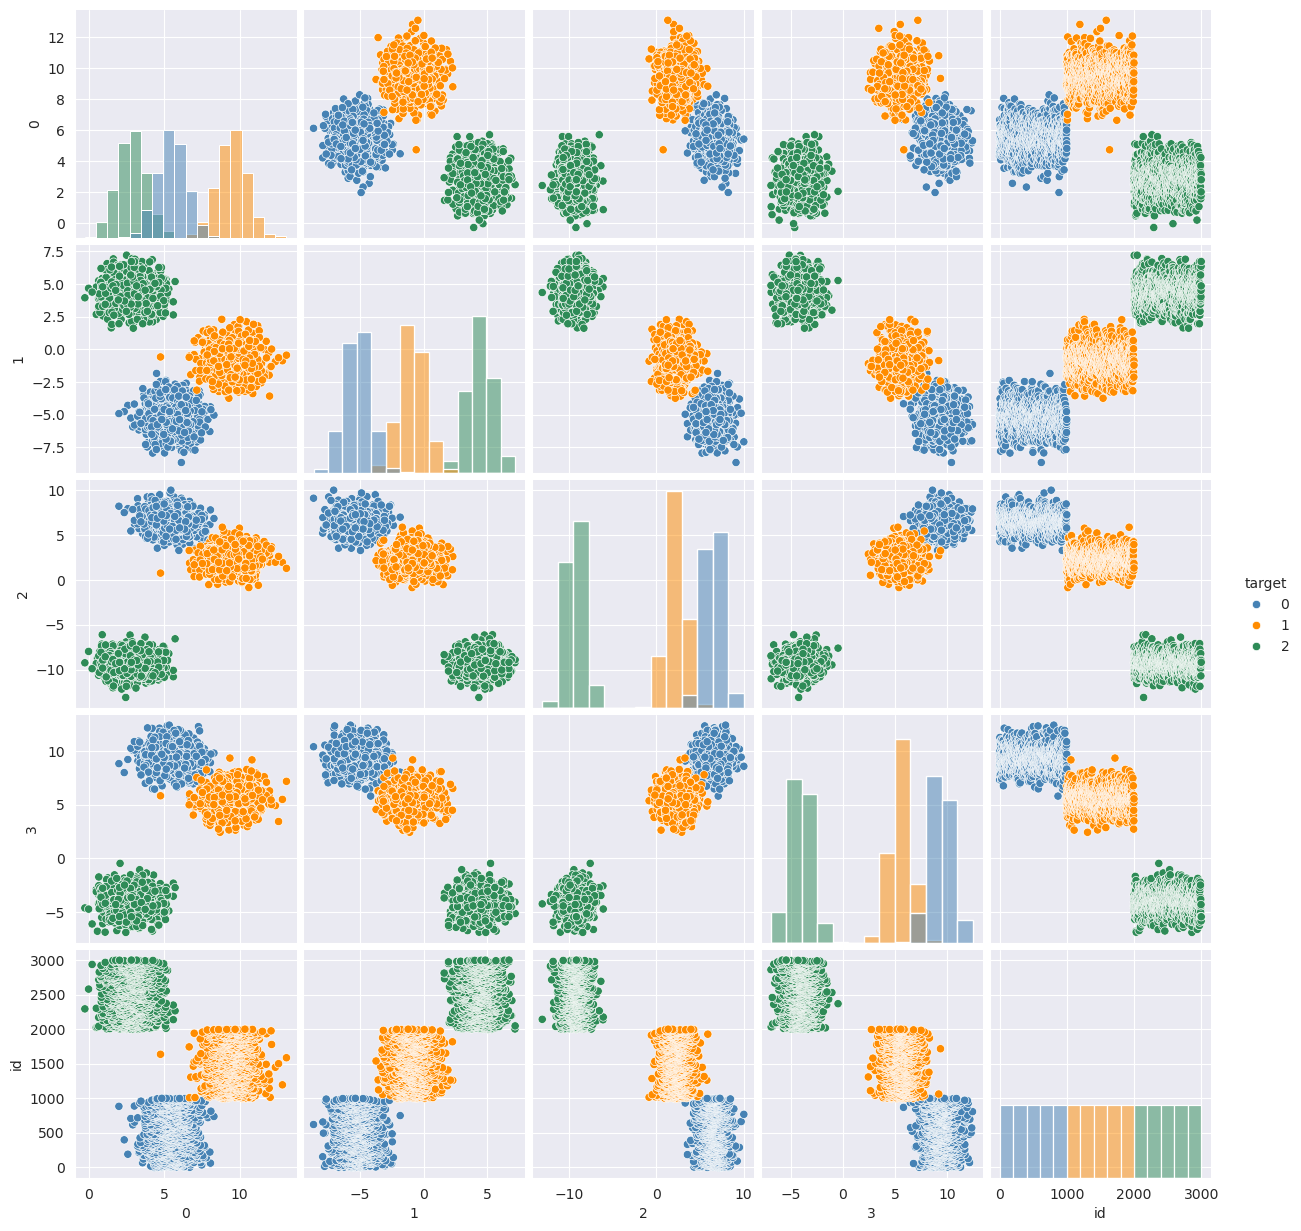

In [6]:
df1['id'] = df1.index

# sns.pairplot(df1, hue='target', palette=['steelblue', 'darkorange', 'seagreen'])
sns.pairplot(df1, hue='target', palette=['steelblue', 'darkorange', 'seagreen'], diag_kind='hist')
plt.show()

[3] На основе созданного в пункте [1] датасета сгенерировать отдельные
дополнительные датасеты (df2, df5, df10…), в которых объекты одного класса
повторены 2 раза, 5 раз, 10 раз, 20 раз, 50 раз, 100 раз, 1000 раз, 10k раз, а
количество объектов в остальных классов неизменно.

In [7]:
def repeat_entries(df, target_class, n_times):
    target_df = df[df['target'] == target_class]
    non_target_df = df[df['target'] != target_class]
    
    repeated_df = pd.concat([target_df] * n_times, ignore_index=True)
    return pd.concat([non_target_df, repeated_df], ignore_index=True)
    
df_multipliers = [1, 2, 5, 10, 20, 50, 100, 1000, 10000]
repeat_df_dict = {}

print("Number of entries for each class in:")
for i in df_multipliers:
    repeat_df_dict[i] = repeat_entries(df1, 0, i)    
    print(f"df{i} - {repeat_df_dict[i]['target'].value_counts().reset_index()['count'].tolist()}")


Number of entries for each class in:
df1 - [1000, 1000, 1000]
df2 - [2000, 1000, 1000]
df5 - [5000, 1000, 1000]
df10 - [10000, 1000, 1000]
df20 - [20000, 1000, 1000]
df50 - [50000, 1000, 1000]
df100 - [100000, 1000, 1000]
df1000 - [1000000, 1000, 1000]
df10000 - [10000000, 1000, 1000]


[4] Выбрать пару классов (включая класс с повторенными объектами) и пару
количественных признаков.

Используя метод LDA (линейный дискриминантный анализ), для каждого из
датасетов df1, df2, df5, df10, df20, df50, df100, df1000, df10k, построить решающую
функцию алгоритма, разграниченные решающей функцией зоны и отдельные
объекты классов.

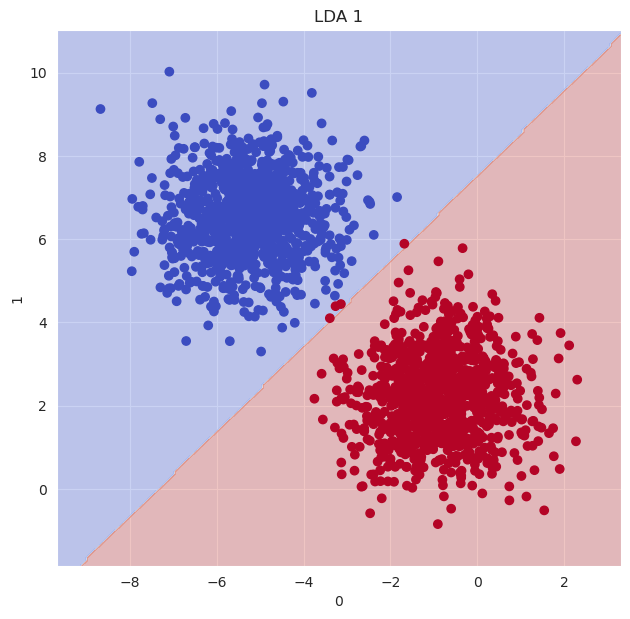

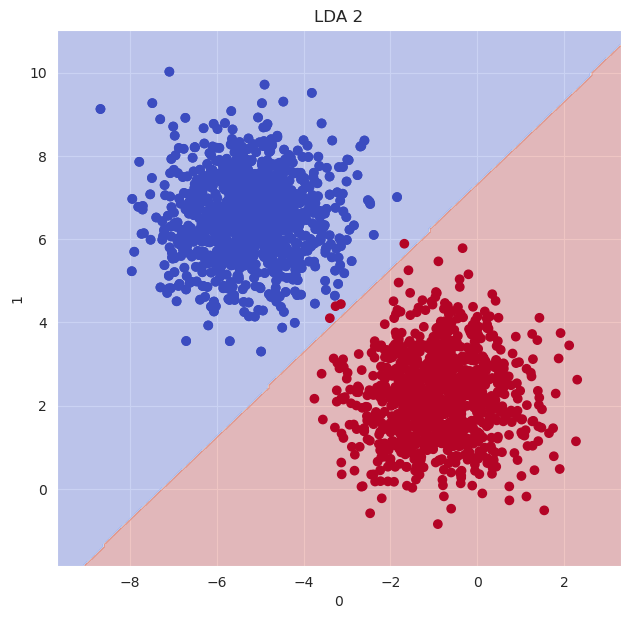

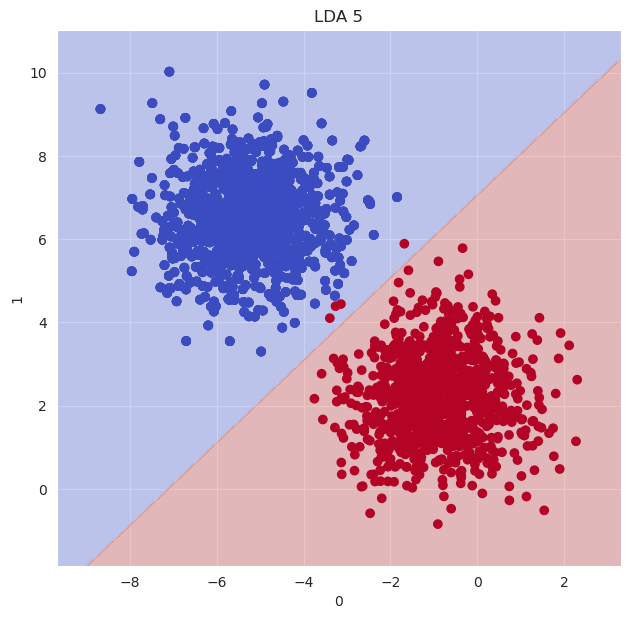

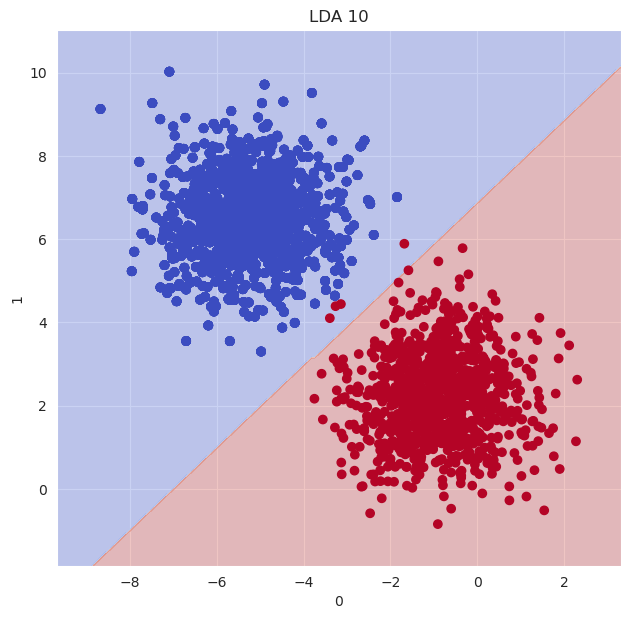

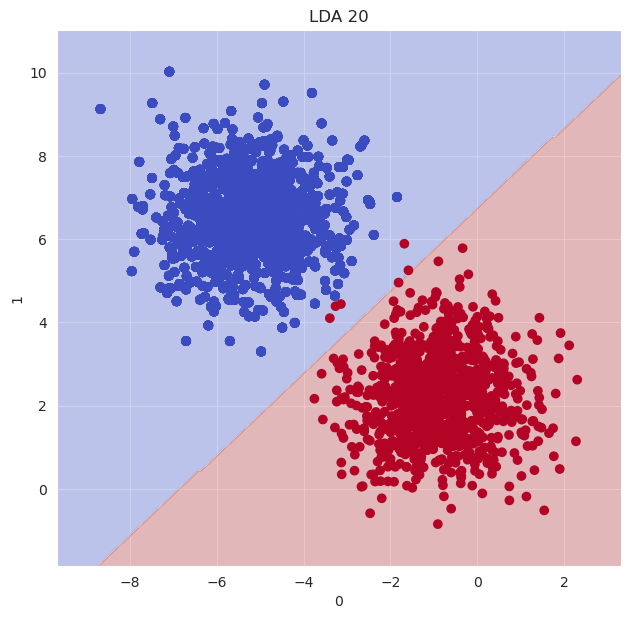

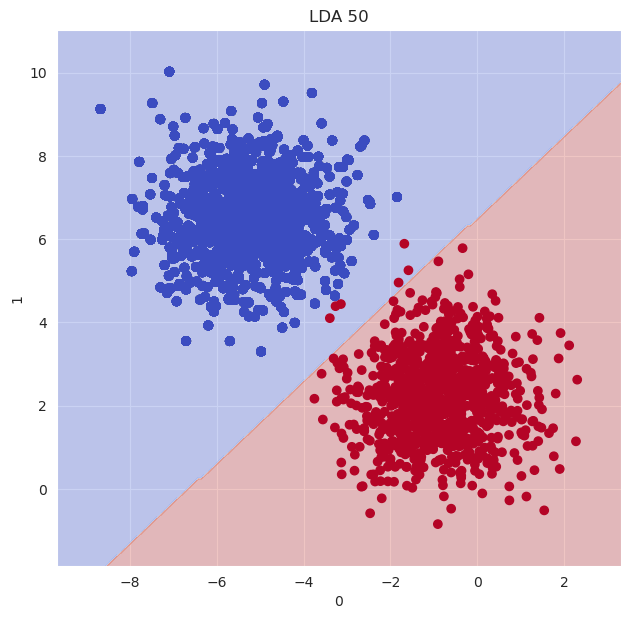

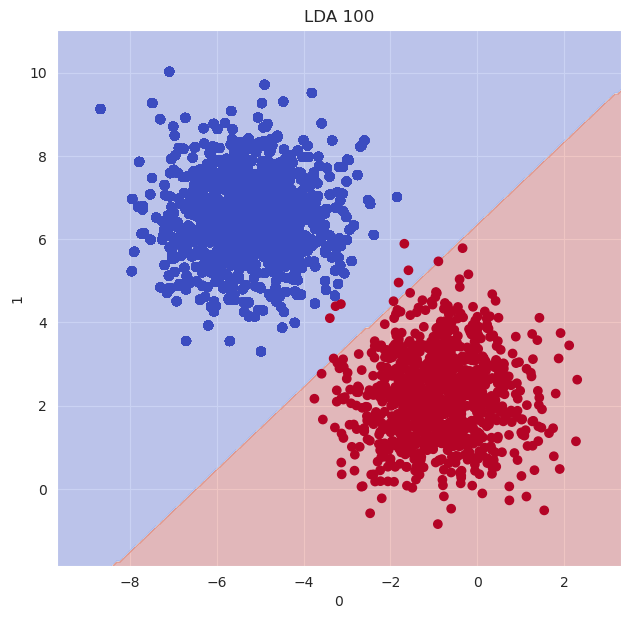

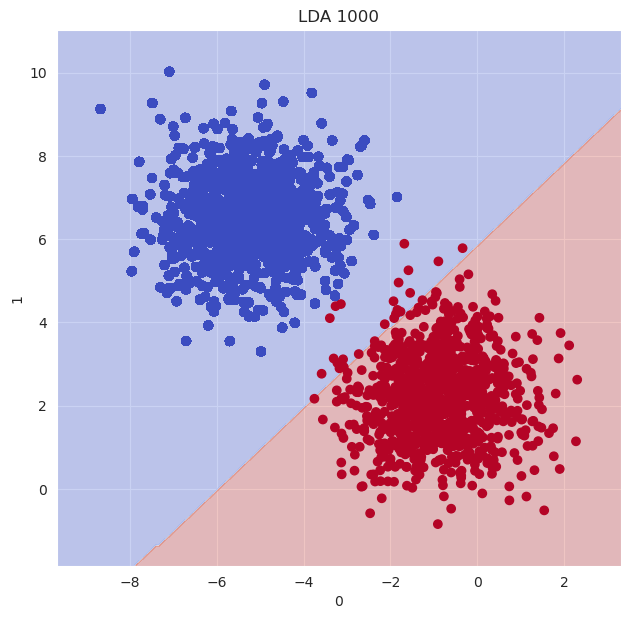

In [ ]:
def extract_classes(df):
    df = df[df['target'].isin([0, 1])]
    return df[[1, 2, 'target']]


classes = [0, 1]
lda_trained = {}
results = {}


def show_lda(df, lda, m):
    filtered_df = extract_classes(df)
    
    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    
    lda.fit(x, y)
    lda_trained[m] = lda
    
    res = lda.predict(np.c_[xx.ravel(), yy.ravel()])
    res = res.reshape(xx.shape)
    results[m] = res

    plt.contourf(xx, yy, res, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.title(f"LDA {m}")
    plt.xlabel("0")
    plt.ylabel("1")


for m in df_multipliers:
    plt.figure(figsize=(8, 8))
    show_lda(repeat_df_dict[m], LDA(), m)
    plt.show()

[5] Повторить пункт [4] для алгоритма SVM.

In [ ]:
svm_results = {}


def show_svm(df, svm, m):
    filtered_df = extract_classes(df)
    
    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    
    svm.fit(x, y)
    res = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    res = res.reshape(xx.shape)
    results[m] = res

    plt.contourf(xx, yy, res, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.title(f"SVM {m}")
    plt.xlabel("0")
    plt.ylabel("1")


for m in df_multipliers:
    plt.figure(figsize=(8, 8))
    show_lda(repeat_df_dict[m], SVM(), m)
    plt.show()

[6] Для каждого из датасетов df1, df2, df5, df10, df20, df50, df100, df1000, df10k из
пункта [4] восстановить в таблицу координаты следующих точек:
- центр отрезка, соединяющего центры масс выбранных классов
- общий центр масс выбранных классов
- точку пересечения решающей функции и отрезка, соединяющего центры масс
выбранных классов.

В виде графиков визуализировать зависимости между количеством повторов в
классе с повторенными объектами и координатами найденных точек.

In [ ]:
class_centers = {}
global_centers = {}
segment_centers = {}
intersections = {}


def compute_points(df, res, lda, m):
    filtered_df = extract_classes(df)
    
    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    
    df_class_0 = filtered_df[filtered_df['target'] == 0]
    df_class_1 = filtered_df[filtered_df['target'] == 1]
    
    center_class_0 = df_class_0[[1, 2]].mean().values
    center_class_1 = df_class_1[[1, 2]].mean().values
    class_centers[m] = [center_class_0, center_class_1]
    
    center_of_segment = (center_class_0 + center_class_1) / 2
    segment_centers[m] = center_of_segment
    
    both_classes = pd.concat([df_class_0, df_class_1], ignore_index=True)
    center_both_classes = both_classes[[1,2]].mean().values
    global_centers[m] = center_both_classes

    w = lda.coef_[0]
    b = lda.intercept_[0]
    
    segment_vector = center_class_1 - center_class_0
    t = -(np.dot(w, center_class_0) + b) / np.dot(w, segment_vector)
    
    intersection_point = center_class_0 + t * segment_vector
    intersections[m] = intersection_point
    
    plt.figure(figsize=(8, 8))

    plt.contourf(xx, yy, res, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.2, cmap=plt.cm.coolwarm)
    
    plt.plot([center_class_0[0], center_class_1[0]], [center_class_0[1], center_class_1[1]], color='yellow', linestyle='--')
    plt.scatter(center_class_0[0], center_class_0[1], color='red', marker='x', s=50, label='Center Class 0')
    plt.scatter(center_class_1[0], center_class_1[1], color='blue', marker='x', s=50, label='Center Class 1')
    plt.scatter(center_of_segment[0], center_of_segment[1], color='green', marker='o', s=50, label='Center of Segment')
    plt.scatter(center_both_classes[0], center_both_classes[1], color='orange', marker='^', s=50, label='Center of Masses')
    plt.scatter(intersection_point[0], intersection_point[1], color='purple', marker='s', s=50, label='Intersection')
    
    plt.title(f"LDA-{m} points")
    plt.legend()
    plt.xlabel("0")
    plt.ylabel("1")
    
    plt.show()
    

for m in df_multipliers:
  compute_points(repeat_df_dict[m], results[m], lda_trained[m], m)

In [2]:
titles = ['Class 0 Center', 'Class 1 Center', 'Center of Segment', 'Global Mass Center', 'Intersection']

coordinates = []
coordinates += [[class_centers[i][0] for i in df_multipliers]]
coordinates += [[class_centers[i][1] for i in df_multipliers]]
coordinates += [[segment_centers[i] for i in df_multipliers]]
coordinates += [[global_centers[i] for i in df_multipliers]]
coordinates += [[intersections[i] for i in df_multipliers]]

for t in range(len(coordinates)):
    plt.figure(figsize=(8, 4))
    plt.plot(df_multipliers, [i[0] for i in coordinates[t]], label='x', marker='o')
    plt.plot(df_multipliers, [i[1] for i in coordinates[t]], label='y', marker='o')
    plt.title(f'{titles[t]}')
    plt.xlabel('Number of Repeats')
    plt.ylabel('Coordinates')
    plt.legend()
    plt.show()

NameError: name 'axes' is not defined

[7] Выбрать целевой класс для решений из пункта [4].

Для каждого из решений из пункта [4]:
- Построить ROC кривую и рассчитать метрику AUROC.
- Построить PR кривую и рассчитать метрику AUPRC.
- (*) Построить PRgain кривую и рассчитать метрику AUPRgainC.

In [3]:
def roc_prc(classes, target_class, m):
    filtered_df = extract_classes(repeat_df_dict[m])
    
    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])
    
    model = lda_trained[m]
    y_pred = model.predict(x)
    # y_pred = model.predict_proba(x)[:, 1]

    pred_df = pd.DataFrame({'true': y, 'pred': y_pred})
    
    tp = ((pred_df['true'] == target_class) & (pred_df['pred'] == target_class)).sum()
    fp = ((pred_df['true'] != target_class) & (pred_df['pred'] == target_class)).sum()
    fn = ((pred_df['true'] == target_class) & (pred_df['pred'] != target_class)).sum()
    tn = ((pred_df['true'] != target_class) & (pred_df['pred'] != target_class)).sum()
    
    print(f'LDA-{m}')
    print(f'Target class: {target_class}')
    print(f'TP: {tp} FP: {fp}')
    print(f'FN: {fn} TN: {tn}')

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    print(f"Sensitivity: {sensitivity:0.3f}, Specificity: {specificity:0.3f}, Precision: {precision:0.3f}")

    fpr, tpr, _ = roc_curve(y, y_pred)
    auroc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y, y_pred)
    auprc = auc(recall, precision)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', linewidth=2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.title(f'LDA-{m}\nAUROC: {auroc:0.2f}')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue')
    plt.plot([0, 1], [1/(1 + m), 1/(1 + m)], color='red', linestyle='--')
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'LDA-{m}\nAUPRC: {auprc:0.2f}')
    plt.grid()
    
    plt.show()



for m in df_multipliers:
    roc_prc([0, 1], 0, m)

NameError: name 'df_multipliers' is not defined

[8] В пункте [7] выбрать другой целевой класс.
- Построить ROC кривую и рассчитать метрику AUROC.
- Построить PR кривую и рассчитать метрику AUPRC.
- (*) Построить PRgain кривую и рассчитать метрику AUPRgainC.

[9] Для датасета 10k на основе 3-fold, 5-fold, 10-fold, 20-fold, 50-fold, 100-fold кросс-
валидации построить кривые AUROC и AUPRC c доверительными интервалами (CI95). 

Вместо CI95 можно взять CI90, CI80 или другой вариант доверительного
интервала.

In [ ]:
df = repeat_df_dict[10000]
df_filtered = df[(df['target'] == 0) | (df['target'] == 1)]

lda = LDA()
    
X = df_filtered.drop(columns=['target']).to_numpy()
X = X[:, :2]
y = df_filtered['target'].to_numpy()

def bootstrap_pr_auc(y_real, y_proba, n_bootstraps=1000, ci=95):
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_proba), len(y_proba))
        if len(np.unique(y_real[indices])) < 2:
            continue

        precision, recall, _ = precision_recall_curve(y_real[indices], y_proba[indices])

        score = auc(recall, precision)
        bootstrapped_scores.append(score)
    
    sorted_scores = np.sort(bootstrapped_scores)
    lower_bound = np.percentile(sorted_scores, (100 - ci) / 2)
    upper_bound = np.percentile(sorted_scores, 100 - (100 - ci) / 2)
    
    return lower_bound, upper_bound

def bootstrap_roc_auc(y_real, y_proba, n_bootstraps=1000, ci=95):
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_proba), len(y_proba))
        if len(np.unique(y_real[indices])) < 2:
            continue

        fpr, tpr, _ = roc_curve(y_real[indices], y_proba[indices])
        score = auc(fpr, tpr)
        bootstrapped_scores.append(score)
    
    sorted_scores = np.sort(bootstrapped_scores)
    lower_bound = np.percentile(sorted_scores, (100 - ci) / 2)
    upper_bound = np.percentile(sorted_scores, 100 - (100 - ci) / 2)
    
    return lower_bound, upper_bound

def viz_folds(df, n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    y_real = []
    y_proba = []
    precision_array = []
    tpr_array = []
    recall_array = np.linspace(0, 1, 100)
    fpr_array = np.linspace(0, 1, 100)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lda.fit(X_train, y_train)
        
        y_pred = lda.predict_proba(X_test)[:, 1]

        precision_fold, recall_fold, _ = precision_recall_curve(y_test, y_pred)
        precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]
        
        prec_array = np.interp(recall_array, recall_fold, precision_fold)
        precision_array.append(prec_array)

        auprc = auc(recall_array, prec_array)
        
        lab_fold_pr = 'Fold %d AUPR=%.4f' % (i+1, auprc)
        axes[0].plot(recall_fold, precision_fold, alpha=0.3)

        fpr_fold, tpr_fold, _ = roc_curve(y_test, y_pred)

        tpr_interp = np.interp(fpr_array, fpr_fold, tpr_fold)
        tpr_arrUntitleday.append(tpr_interp)

        auroc = auc(fpr_fold, tpr_fold)

        lab_fold_roc = 'Fold %d AUROC=%.4f' % (i+1, auroc)
        axes[1].plot(fpr_fold, tpr_fold, alpha=0.3)
     
        y_real.append(y_test)
        y_proba.append(y_pred)

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)

    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    lab_pr = 'Overall AUPR=%.4f' % (auc(recall, precision))
    axes[0].plot(recall, precision, lw=2, color='red', label=lab_pr)

    fpr, tpr, _ = roc_curve(y_real, y_proba)
    lab_roc = 'Overall AUROC=%.4f' % (auc(fpr, tpr))
    axes[1].plot(fpr, tpr, lw=2, color='red', label=lab_roc)
    
    lower_ci_pr, upper_ci_pr = bootstrap_pr_auc(y_real, y_proba, n_bootstraps=1000, ci=95)
    mean_precision = np.mean(precision_array, axis=0)
    std_precision = np.std(precision_array, axis=0)
    
    ci_lower_pr, ci_upper_pr = mean_precision - std_precision, mean_precision + std_precision
    axes[0].fill_between(recall_array, ci_lower_pr, ci_upper_pr, alpha=0.2, color='blue', label=f'95% Confidence Interval [{lower_ci_pr:.4f}, {upper_ci_pr:.4f}]')
    
    lower_ci_roc, upper_ci_roc = bootstrap_roc_auc(y_real, y_proba, n_bootstraps=1000, ci=95)
    mean_tpr = np.mean(tpr_array, axis=0)
    std_tpr = np.std(tpr_array, axis=0)
    
    ci_lower_roc, ci_upper_roc = mean_tpr - std_tpr, mean_tpr + std_tpr
    axes[1].fill_between(fpr_array, ci_lower_roc, ci_upper_roc, alpha=0.2, color='blue', label=f'95% Confidence Interval [{lower_ci_roc:.4f}, {upper_ci_roc:.4f}]')
    
    axes[0].legend(loc='lower left', fontsize='small')
    axes[0].set_title("PR curves with confidence interval 95%; {} folds".format(skf.n_splits), weight="bold", fontsize=16)
    axes[0].set_xlabel("Recall (Sensitivity)")
    axes[0].set_ylabel("Precision (PPV)")
    
    axes[1].legend(loc='lower right', fontsize='small')
    axes[1].set_title("ROC curves with confidence interval 95%; {} folds".format(skf.n_splits), weight="bold", fontsize=16)
    axes[1].set_xlabel("1 - Specificity")
    axes[1].set_ylabel("Sensetivity")
    
    plt.tight_layout()
    plt.show()


folds = [3, 5, 10, 20, 50, 100]
for k in folds:
    viz_folds(df_filtered, k)